In [210]:
import os

run_identifier = 'balancedLoss'

plots_subdir = f'../plots/{run_identifier}'
if not os.path.exists(plots_subdir):
    os.makedirs(plots_subdir)

In [211]:
import glob
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, \
    f1_score, matthews_corrcoef, precision_score, recall_score

result_dir = '../results/classification'
metrics = pd.DataFrame(columns=['Maximum Sequence Length', 'Cutting Method', 'Number of Epochs', 'TP', 'TN', 'FP', 'FN',
                                'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1S', 'MCC'])

for mx in [4, 6, 8]:
    for cut in ['After', 'Before']:
        gt = pd.read_csv(f'{result_dir}/max{mx}_cut{cut}/gt_test_labels.csv')

        for epochs in [15, 30]:
            pred_files = [i for i in glob.glob(f'{result_dir}/max{mx}_cut{cut}/{epochs}epochs/*.csv')]
            pred = pd.concat([pd.read_csv(f) for f in pred_files])
            merged = pd.merge(gt, pred, left_on='Read ID', right_on='Read ID')

            metrics = pd.concat([metrics, pd.DataFrame([{
                'Maximum Sequence Length': mx,
                'Cutting Method': cut,
                'Number of Epochs': epochs,
                'TP': len(merged[(merged['Predicted Label'] == 'plasmid') & (merged['GT Label'] == 'plasmid')]),
                'TN': len(merged[(merged['Predicted Label'] == 'chr') & (merged['GT Label'] == 'chr')]),
                'FP': len(merged[(merged['Predicted Label'] == 'plasmid') & (merged['GT Label'] == 'chr')]),
                'FN': len(merged[(merged['Predicted Label'] == 'chr') & (merged['GT Label'] == 'plasmid')]),
                'Accuracy': accuracy_score(merged['GT Label'], merged['Predicted Label']),
                # (TP + TN) / (TP + TN + FP + FN)
                'Balanced Accuracy': balanced_accuracy_score(merged['GT Label'], merged['Predicted Label']),
                # (TPR + TNR) / 2
                'Precision': precision_score(merged['GT Label'], merged['Predicted Label'], pos_label='plasmid'),
                # TP / (TP + FP)
                'Recall': recall_score(merged['GT Label'], merged['Predicted Label'], pos_label='plasmid'),
                # TPR: TP / (TP + FN)
                'F1S': f1_score(merged['GT Label'], merged['Predicted Label'], pos_label='plasmid'),
                # harmonic mean between precision and recall
                'MCC': matthews_corrcoef(merged['GT Label'], merged['Predicted Label']),
            }])], ignore_index=True)

            cm = confusion_matrix(merged['GT Label'], merged['Predicted Label'], labels=['chr', 'plasmid'])
            cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
            cm_display.plot()
            plt.title(f'Confusion Matrix of Plasmid Classification\n'
                      f'(max sequence length: {mx}k, cutted: {cut.lower()} normalization, epochs: {epochs})')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig(f'{plots_subdir}/max{mx}_cut{cut}_epochs{epochs}_confusion_matrix.png', dpi=300, facecolor='white')
            plt.close()

In [212]:
metrics['TNR'] = metrics['TN'] / (metrics['TN'] + metrics['FP'])  # specificity
metrics['FPR'] = metrics['FP'] / (metrics['FP'] + metrics['TN'])  # 1 - specificity
metrics['FNR'] = metrics['FN'] / (metrics['FN'] + metrics['TP'])

In [214]:
metrics['ID'] = 'max' + metrics['Maximum Sequence Length'].astype(str) + '_cut' + metrics['Cutting Method'] \
                + '_ep' + metrics['Number of Epochs'].astype(str)
metrics.to_csv(f'{result_dir}/metrics_{run_identifier}.csv', index=False)
metrics

,Maximum Sequence Length,Cutting Method,Number of Epochs,TP,TN,FP,FN,Accuracy,Balanced Accuracy,Precision,Recall,F1S,MCC,TNR,FPR,FNR,ID
0,4,After,15,10461,162534,60867,6032,0.721131,0.680906,0.146660,0.634269,0.238235,0.200291,0.727544,0.272456,0.365731,max4_cutAfter_ep15
1,4,After,30,10640,163489,59912,5853,0.725858,0.688470,0.150811,0.645122,0.244471,0.209329,0.731819,0.268181,0.354878,max4_cutAfter_ep30
2,4,Before,15,11632,143191,80210,4861,0.645381,0.673114,0.126652,0.705269,0.214741,0.180230,0.64096,0.35904,0.294731,max4_cutBefore_ep15
3,4,Before,30,11096,161069,62332,5397,0.717671,0.696878,0.151114,0.672770,0.246794,0.216185,0.720986,0.279014,0.32723,max4_cutBefore_ep30
4,6,After,15,10753,151995,48005,5470,0.752686,0.711400,0.183005,0.662824,0.286819,0.250374,0.759975,0.240025,0.337176,max6_cutAfter_ep15
5,6,After,30,11607,148728,51272,4616,0.741526,0.729553,0.184593,0.715466,0.293469,0.266322,0.74364,0.25636,0.284534,max6_cutAfter_ep30
6,6,Before,15,11446,146101,53899,4777,0.728632,0.718023,0.175163,0.705542,0.280649,0.250146,0.730505,0.269495,0.294458,max6_cutBefore_ep15
7,6,Before,30,11503,151266,48734,4720,0.752783,0.732693,0.190962,0.709055,0.300889,0.273476,0.75633,0.24367,0.290945,max6_cutBefore_ep30
8,8,After,15,11266,137974,40869,4705,0.766064,0.738442,0.216093,0.705404,0.330837,0.295509,0.771481,0.228519,0.294596,max8_cutAfter_ep15
9,8,After,30,11086,141388,37455,4885,0.782664,0.742352,0.228384,0.694133,0.343688,0.307427,0.790571,0.209429,0.305867,max8_cutAfter_ep30


,Maximum Sequence Length,Cutting Method,Number of Epochs,TP,TN,FP,FN,Accuracy,Balanced Accuracy,Precision,Recall,F1S,MCC,TNR,FPR,FNR,ID
0,4,After,15,10461,162534,60867,6032,0.721131,0.680906,0.146660,0.634269,0.238235,0.200291,0.727544,0.272456,0.365731,max4_cutAfter_ep15
1,4,After,30,10640,163489,59912,5853,0.725858,0.688470,0.150811,0.645122,0.244471,0.209329,0.731819,0.268181,0.354878,max4_cutAfter_ep30
2,4,Before,15,11632,143191,80210,4861,0.645381,0.673114,0.126652,0.705269,0.214741,0.180230,0.64096,0.35904,0.294731,max4_cutBefore_ep15
3,4,Before,30,11096,161069,62332,5397,0.717671,0.696878,0.151114,0.672770,0.246794,0.216185,0.720986,0.279014,0.32723,max4_cutBefore_ep30
4,6,After,15,10753,151995,48005,5470,0.752686,0.711400,0.183005,0.662824,0.286819,0.250374,0.759975,0.240025,0.337176,max6_cutAfter_ep15
5,6,After,30,11607,148728,51272,4616,0.741526,0.729553,0.184593,0.715466,0.293469,0.266322,0.74364,0.25636,0.284534,max6_cutAfter_ep30
6,6,Before,15,11446,146101,53899,4777,0.728632,0.718023,0.175163,0.705542,0.280649,0.250146,0.730505,0.269495,0.294458,max6_cutBefore_ep15
7,6,Before,30,11503,151266,48734,4720,0.752783,0.732693,0.190962,0.709055,0.300889,0.273476,0.75633,0.24367,0.290945,max6_cutBefore_ep30
8,8,After,15,11266,137974,40869,4705,0.766064,0.738442,0.216093,0.705404,0.330837,0.295509,0.771481,0.228519,0.294596,max8_cutAfter_ep15
9,8,After,30,11086,141388,37455,4885,0.782664,0.742352,0.228384,0.694133,0.343688,0.307427,0.790571,0.209429,0.305867,max8_cutAfter_ep30


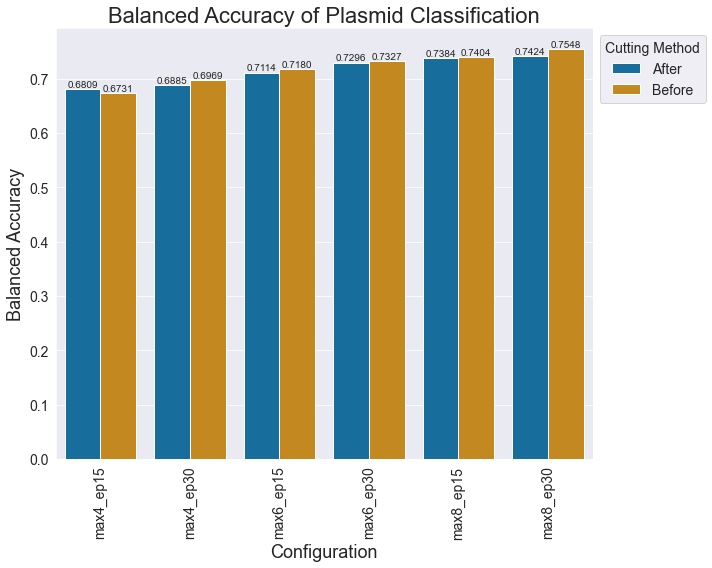

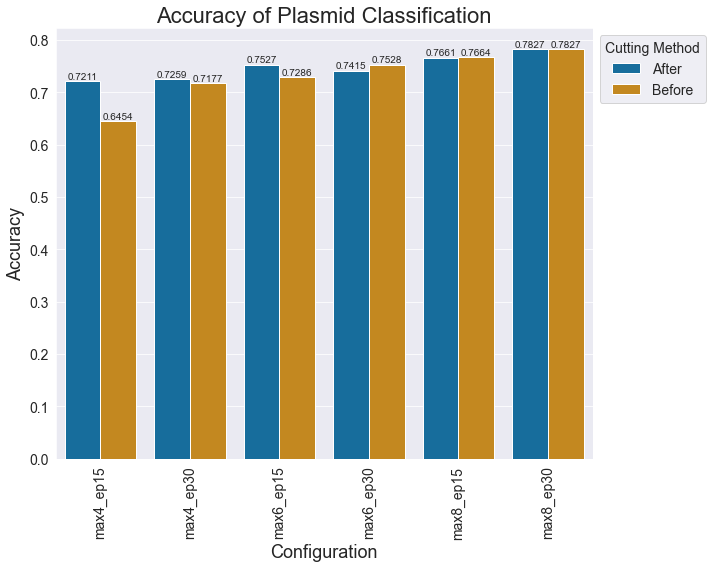

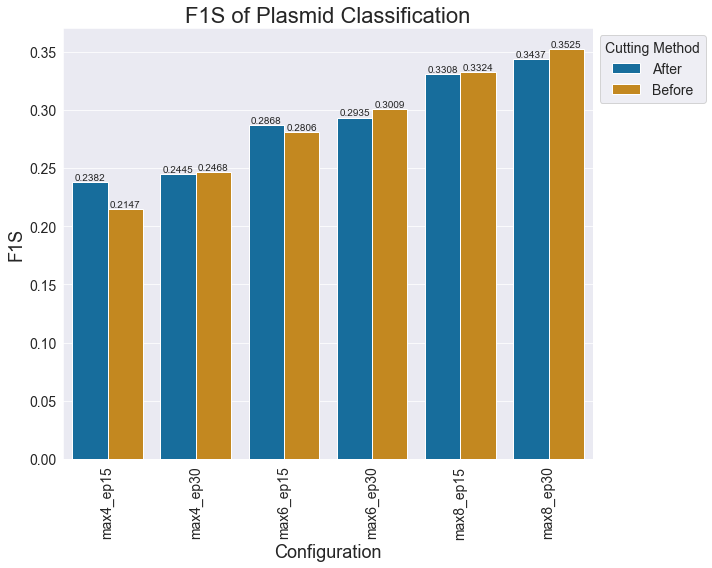

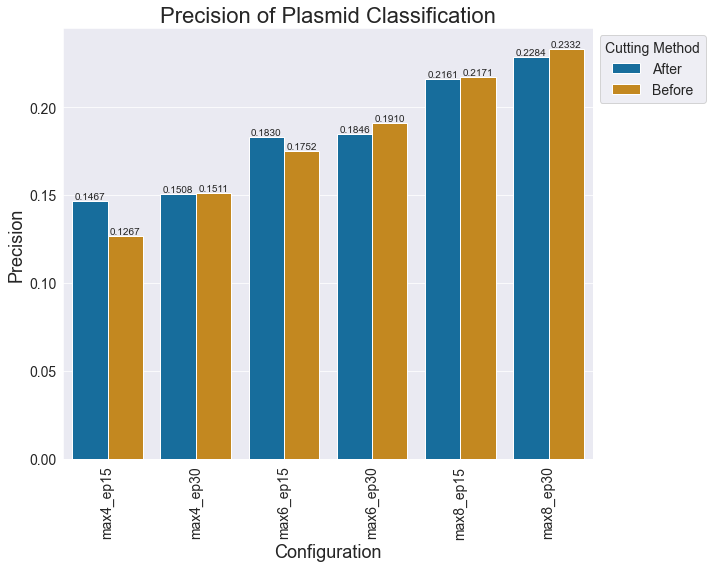

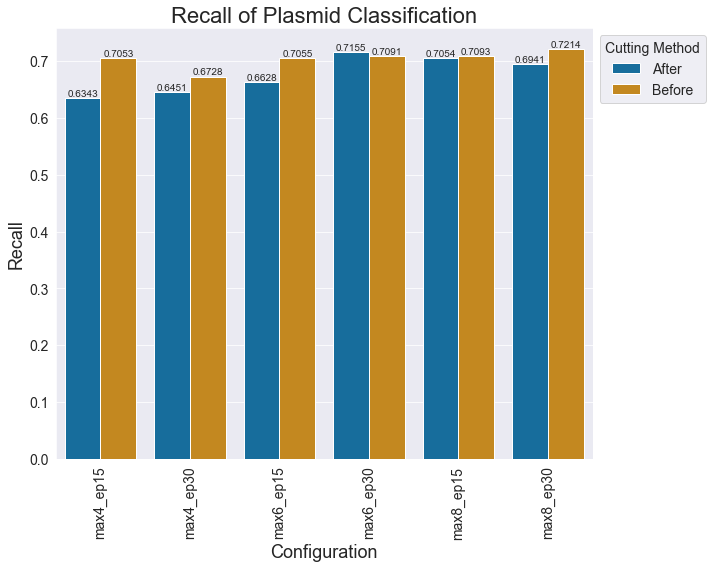

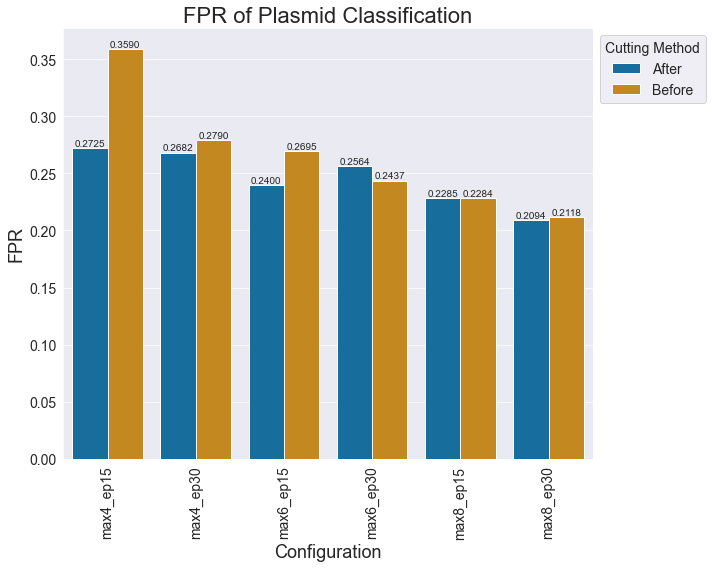

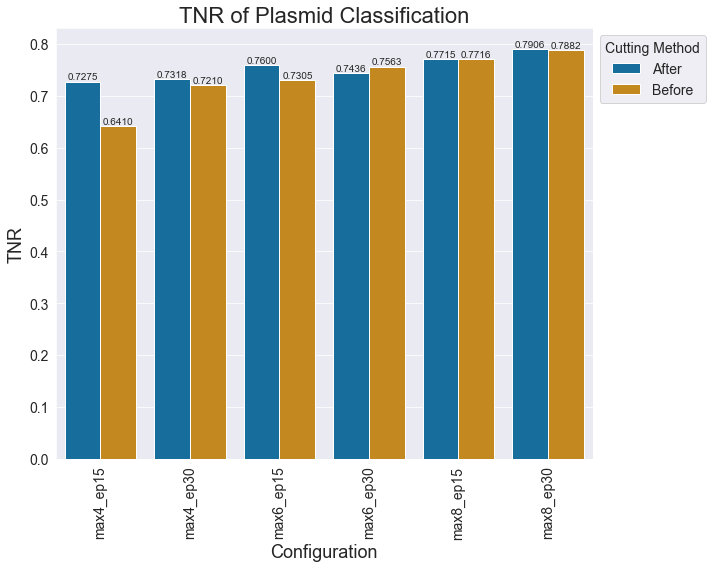

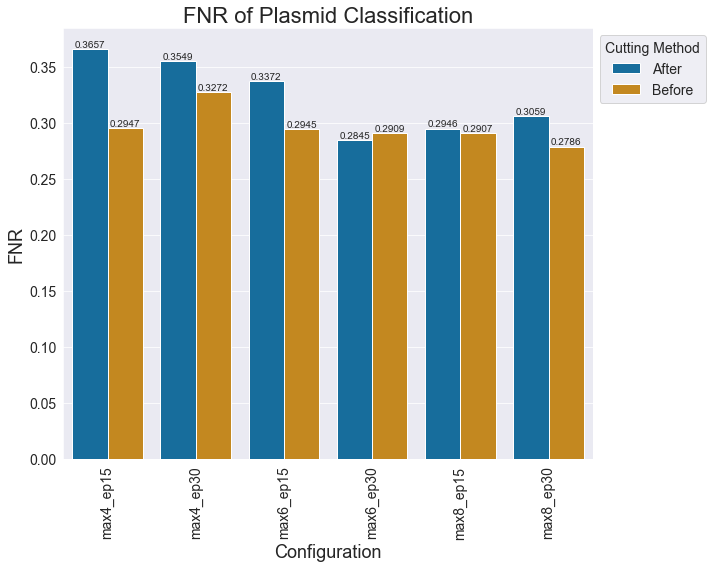

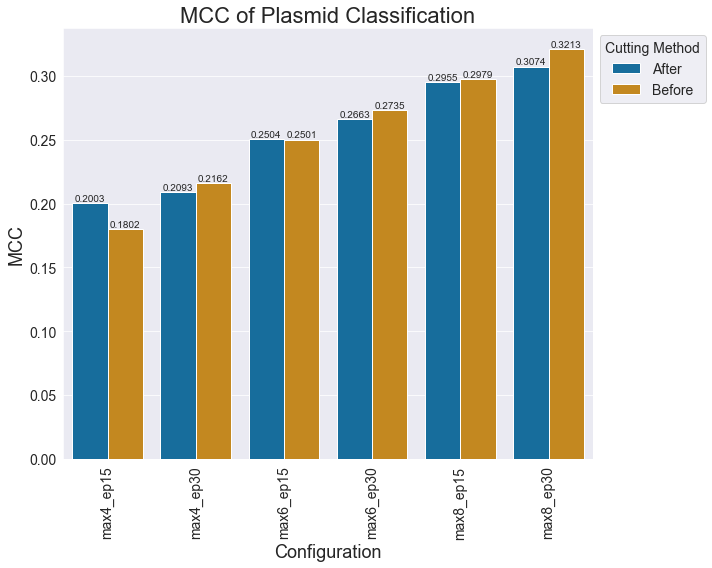

In [215]:
import seaborn as sns

plotdata = metrics.copy()
plotdata = plotdata.replace(['cutAfter_', 'cutBefore_'], ['', ''], regex=True)

# plot each metric separately
for metric in ['Balanced Accuracy', 'Accuracy', 'F1S', 'Precision', 'Recall', 'FPR', 'TNR', 'FNR', 'MCC']:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(data=plotdata,
                x='ID',
                y=metric,
                hue='Cutting Method',
                palette=sns.color_palette('colorblind'))

    # place y-values above bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.4f')

    plt.title(f'{metric} of Plasmid Classification', fontsize=22)
    plt.xlabel('Configuration', fontsize=18)
    plt.ylabel(metric, fontsize=18)
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14
    ax.legend(title='Cutting Method', fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.savefig(f'{plots_subdir}/{metric}.png', dpi=300, facecolor='white')
    #plt.close()

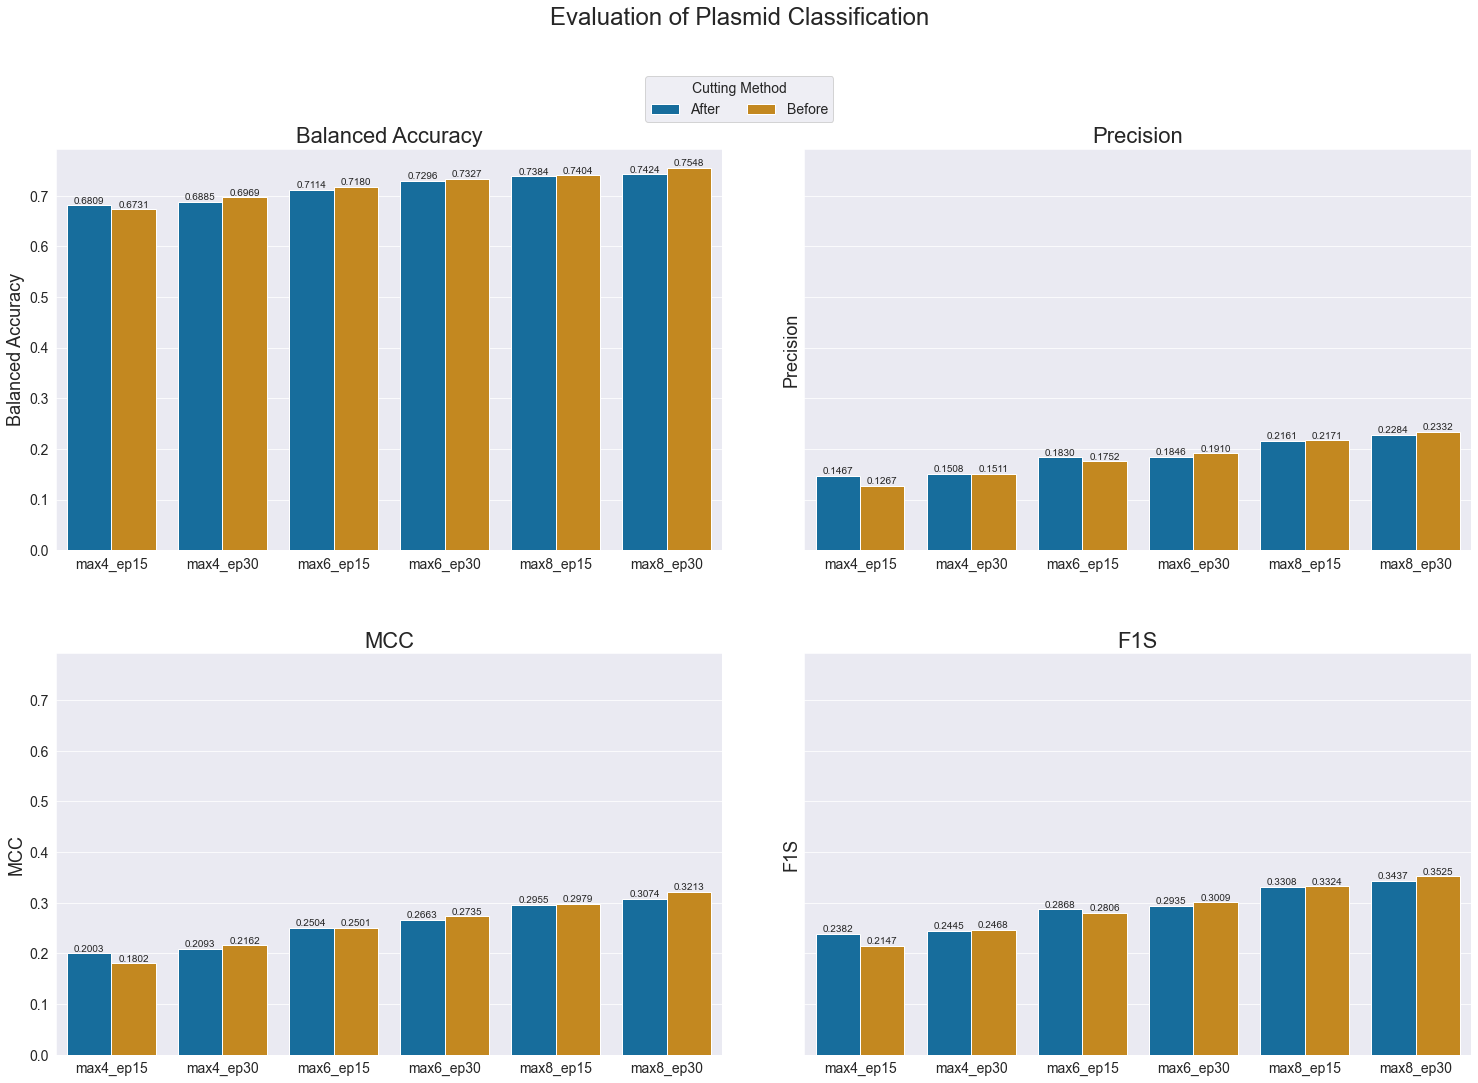

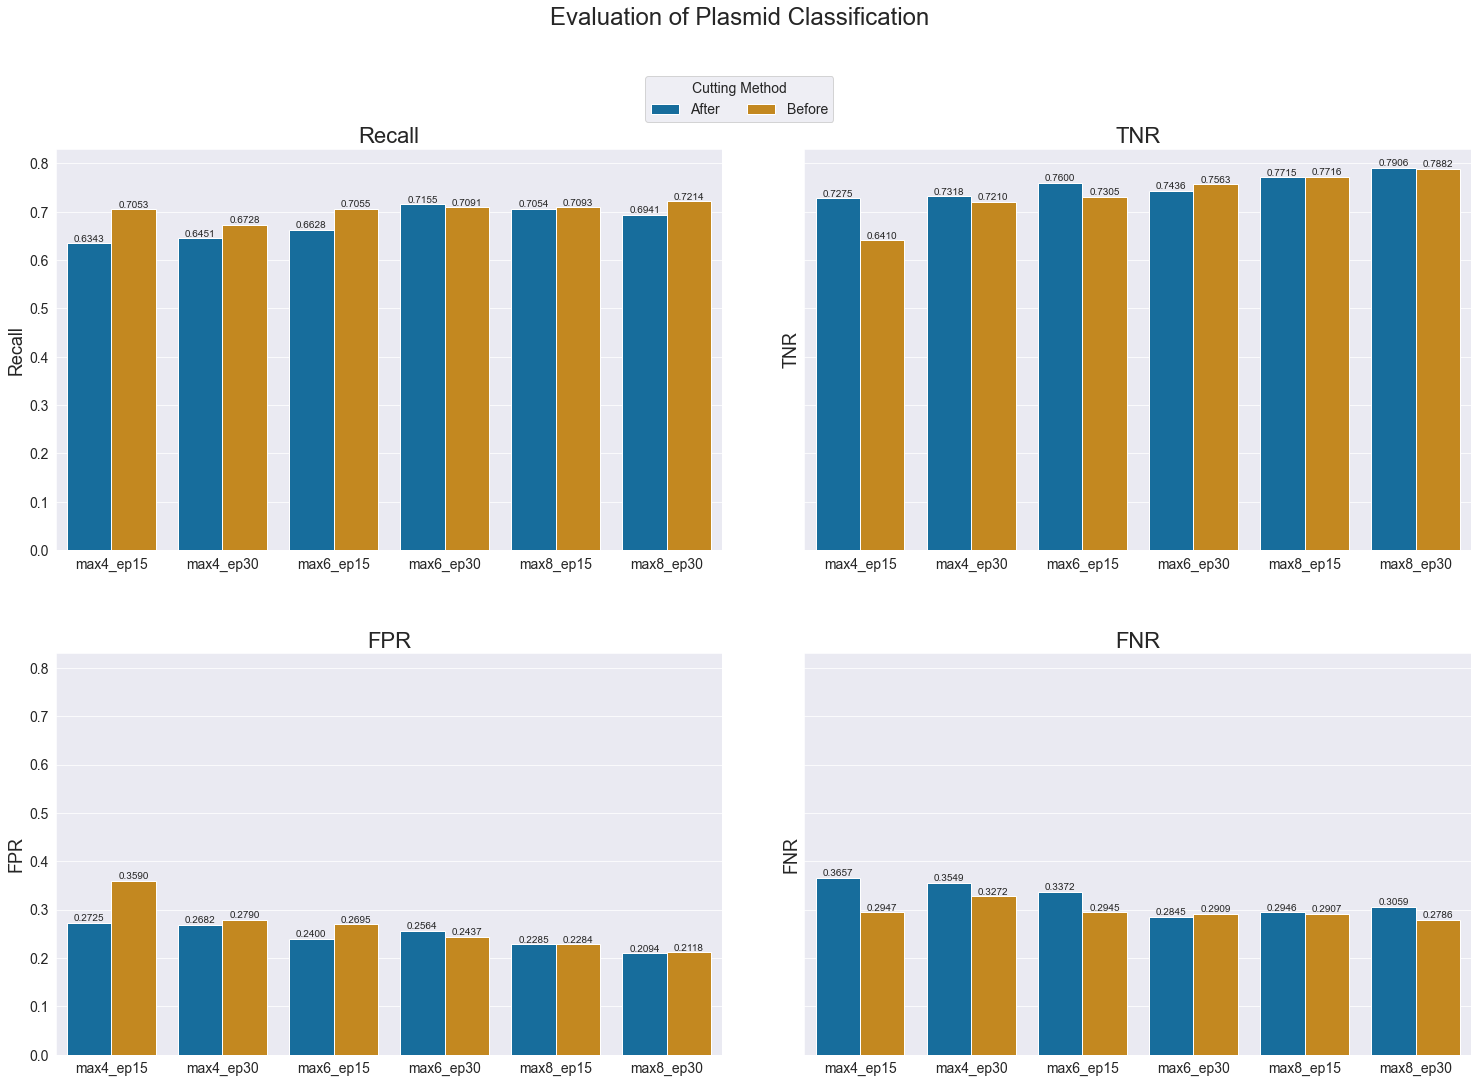

In [216]:
import seaborn as sns

plotdata = metrics.copy()
plotdata = plotdata.replace(['cutAfter_', 'cutBefore_'], ['', ''], regex=True)

# plot 4 metrics at once for better comparability
for metric_collection in [['Balanced Accuracy', 'Precision', 'MCC', 'F1S'], ['Recall', 'TNR', 'FPR', 'FNR']]:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 16), sharey=True)
    plt.rcParams['legend.title_fontsize'] = 14
    ax = axes.flatten()

    for i, metric in enumerate(metric_collection):
        sns.barplot(data=plotdata,
                    x='ID',
                    y=metric,
                    hue='Cutting Method',
                    palette=sns.color_palette('colorblind'),
                    ax=ax[i])

        # place y-values above bars
        for val in ax[i].containers:
            ax[i].bar_label(val, fmt='%.4f')

        # hide legend of subplot
        ax[i].get_legend().remove()

        ax[i].set_title(metric, fontsize=22)
        ax[i].set_xlabel('', fontsize=18)
        ax[i].set_ylabel(metric, fontsize=18)
        ax[i].tick_params(axis="x", labelsize=14)
        ax[i].tick_params(axis="y", labelsize=14)

    plt.suptitle('Evaluation of Plasmid Classification', fontsize=24)
    handles, labels = ax[0].get_legend_handles_labels()
    plt.figlegend(handles, labels, title='Cutting Method', ncol=2, fontsize=14, loc='center', bbox_to_anchor=(0.5, 0.9))
    plt.tight_layout(pad=6.0)
    plt.savefig(f'{plots_subdir}/{"_".join(metric_collection)}.png', dpi=300, facecolor='white')
    #plt.close()

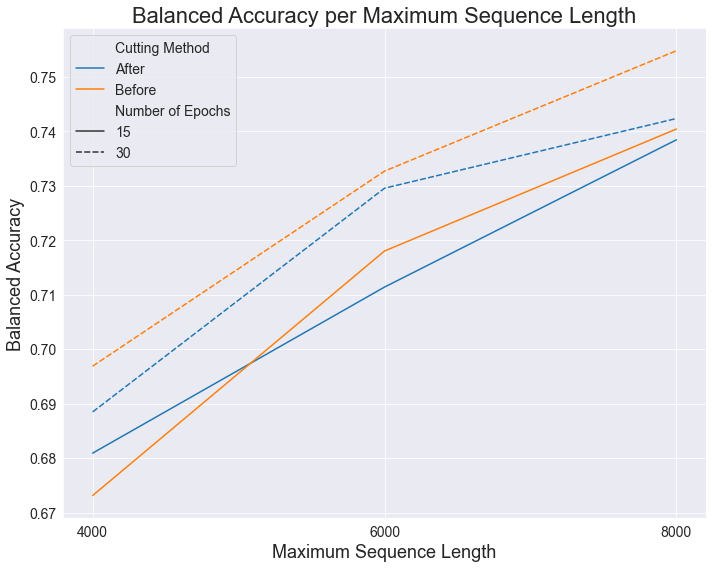

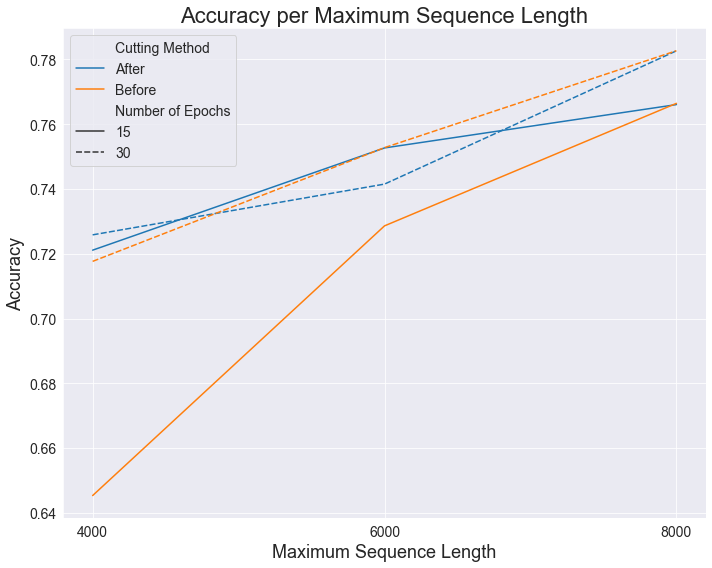

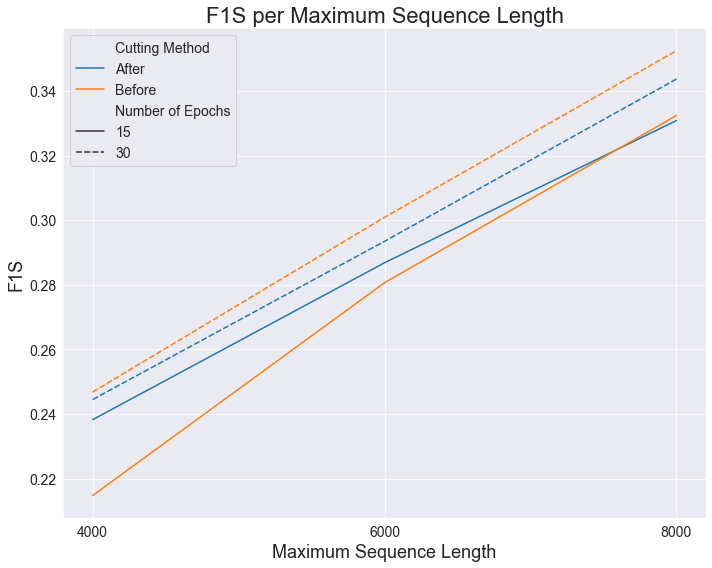

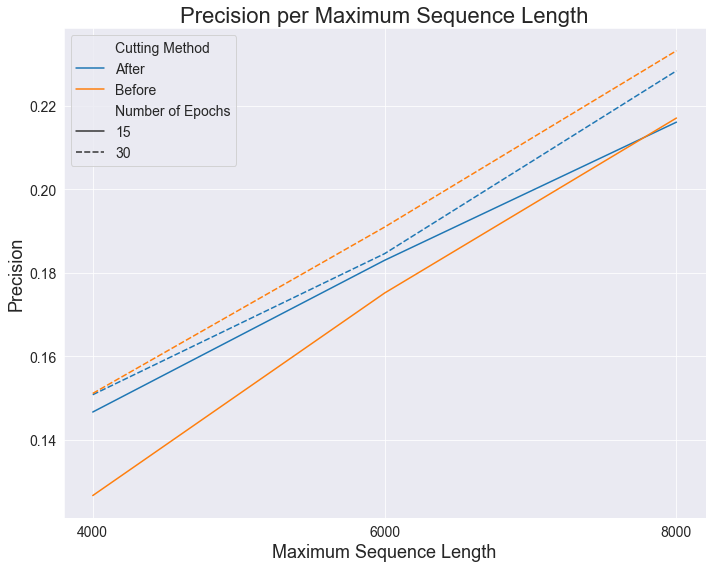

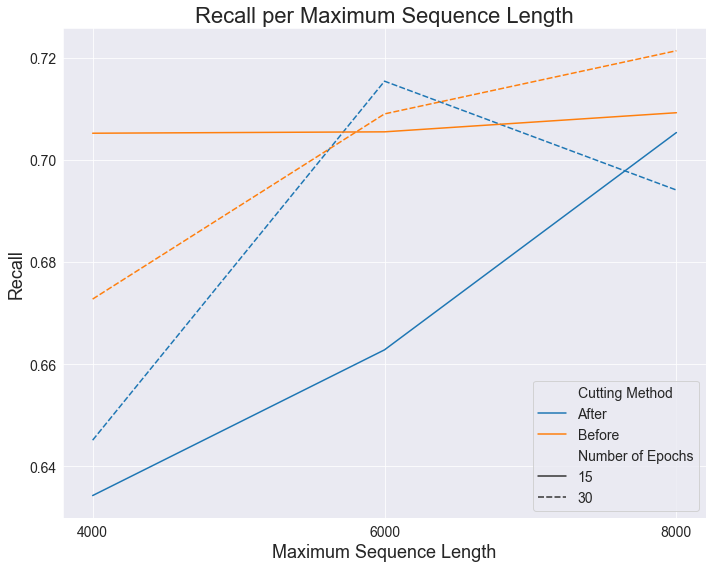

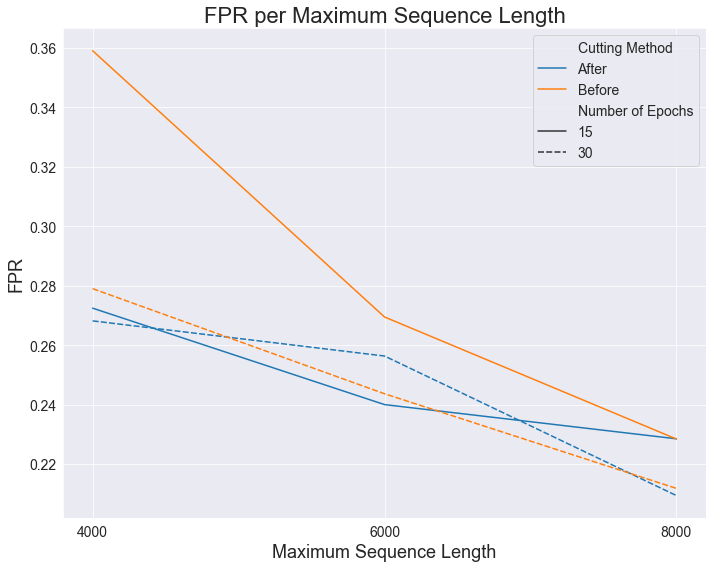

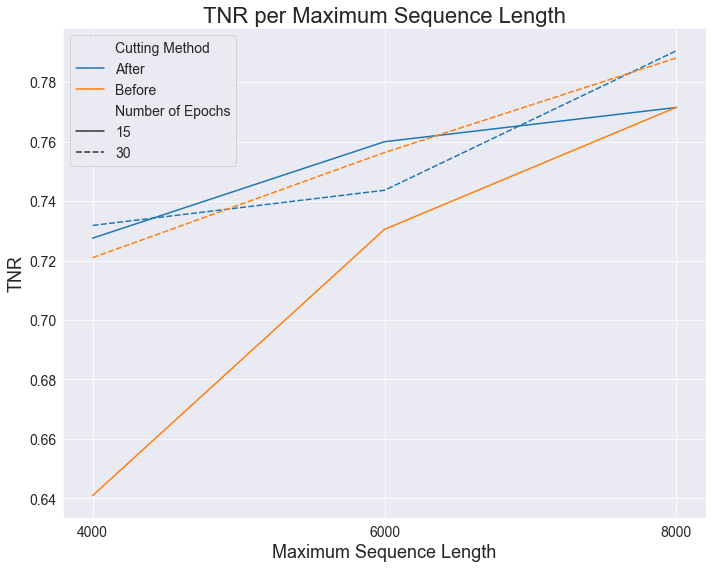

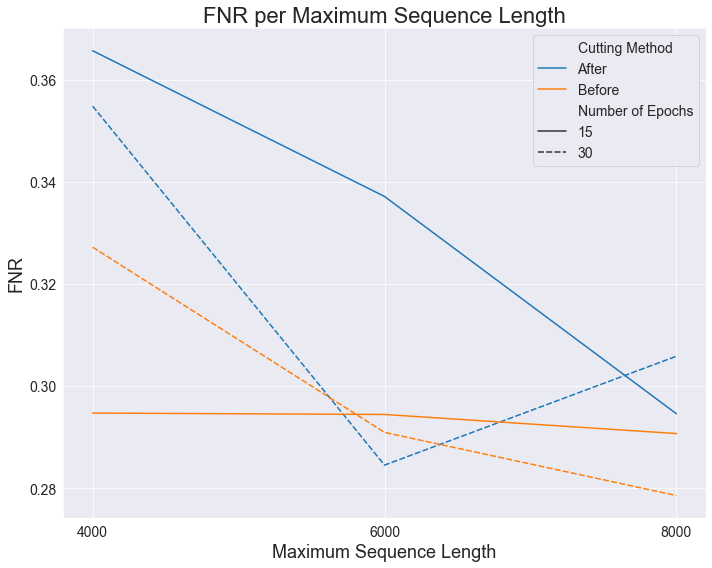

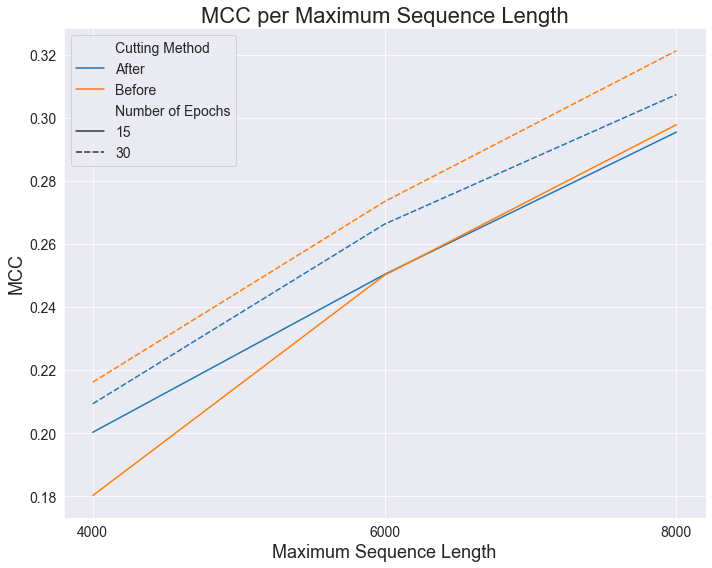

In [217]:
import seaborn as sns

# compare metrics per chosen maximum sequence length
plotdata = metrics.copy()
for metric in ['Balanced Accuracy', 'Accuracy', 'F1S', 'Precision', 'Recall', 'FPR', 'TNR', 'FNR', 'MCC']:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.lineplot(data=plotdata,
                 x='Maximum Sequence Length',
                 y=metric,
                 hue='Cutting Method',
                 style='Number of Epochs')

    plt.title(f'{metric} per Maximum Sequence Length', fontsize=22)
    plt.xlabel('Maximum Sequence Length', fontsize=18)
    plt.ylabel(metric, fontsize=18)
    plt.xticks(fontsize=14, ticks=plotdata['Maximum Sequence Length'], labels=plotdata['Maximum Sequence Length'].astype(str) + '000')
    plt.locator_params(axis='x', nbins=3)
    plt.yticks(fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14
    ax.legend(fontsize=14)

    plt.tight_layout()
    plt.savefig(f'{plots_subdir}/{metric}_per_max.png', dpi=300, facecolor='white')
    #plt.close()

In [218]:
import glob
import os

# extract runtimes from log files
runtimes = pd.DataFrame(columns=['Maximum Sequence Length', 'Cutting Method', 'Number of Epochs', 'Runtime (min)'])

for filepath in glob.glob(f'{result_dir}/*_{run_identifier}.txt'):
    last_line = open(filepath, 'r').readlines()[-1]
    filename_splitted = os.path.basename(filepath).split('_')

    runtimes = pd.concat([runtimes,
                         pd.DataFrame([{'Maximum Sequence Length': filename_splitted[1][-1],
                                        'Cutting Method': filename_splitted[2][3:],
                                        'Number of Epochs': filename_splitted[3][:-10],
                                        'Runtime (min)': float(last_line.split(' ')[3]) / 60}])],
                         ignore_index=True)

runtimes

,Maximum Sequence Length,Cutting Method,Number of Epochs,Runtime (min)
0,4,After,,7.806276
1,4,After,,7.838236
2,4,Before,,7.801675
3,4,Before,,7.808062
4,6,After,,8.520823
5,6,After,,8.603763
6,6,Before,,8.411590
7,6,Before,,8.472782
8,8,After,,9.092389
9,8,After,,8.847099


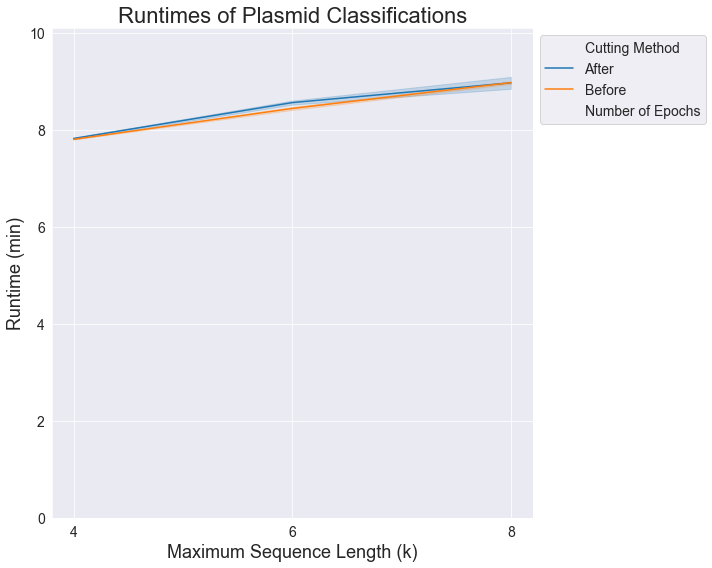

In [219]:
import seaborn as sns

# plot runtimes
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=runtimes,
            x='Maximum Sequence Length',
            y='Runtime (min)',
            hue='Cutting Method',
            style='Number of Epochs')

# place y-values above bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f')

plt.title(f'Runtimes of Plasmid Classifications', fontsize=22)
ax.set(ylim=(0, runtimes['Runtime (min)'].max() + 1))
plt.xlabel('Maximum Sequence Length (k)', fontsize=18)
plt.ylabel('Runtime (min)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams['legend.title_fontsize'] = 14
ax.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig(f'{plots_subdir}/runtimes.png', dpi=300, facecolor='white')
#plt.close()